In [30]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData

from matplotlib.colors import LogNorm

from ccdproc import Combiner
from ccdproc import wcs_project

import inspect
import importlib

# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import downloader 
import refcat
import imagehandler
import known

importlib.reload(downloader)
importlib.reload(refcat)
importlib.reload(imagehandler)
importlib.reload(known)

<module 'known' from '/home/mikea/GitHub/shifty/shifty/known.py'>

# DataHandler
This class is used for handling the data. It contains several DataEnsemble objects within it, and methods for manipulating them.  
These methods exist:
- integer_shift - shift image data by an integer number of pixels. 
- stack - stacks all the data arrays, either shifted or non-shifted (keyword controlled).
- save_stack - saves a stacked array to a fits file.
- save_shift - saves the shifted arrays to fits files.

In [31]:
# I'm gonna define this flag, so that it's easy to switch between
# using both nights (24 images) and just the second night (12 images).
# Only the last 12 images are in GitHub repo.
both_nights=False
#both_nights=True
#Then define a bunch of filenames:
importlib.reload(imagehandler)
filename = '../dev_data/2015RS281_HSC20160826_112.fits'
if both_nights:
    filenames=[filename.replace('100', str(i)) for i in np.arange(100, 124)]
    filenames[-12:]=[filenamei.replace('0825', '0826') for filenamei in filenames[-12:]]
else:
    filenames=[filename.replace('112', str(i)) for i in np.arange(112, 124)]

filenames

['../dev_data/2015RS281_HSC20160826_112.fits',
 '../dev_data/2015RS281_HSC20160826_113.fits',
 '../dev_data/2015RS281_HSC20160826_114.fits',
 '../dev_data/2015RS281_HSC20160826_115.fits',
 '../dev_data/2015RS281_HSC20160826_116.fits',
 '../dev_data/2015RS281_HSC20160826_117.fits',
 '../dev_data/2015RS281_HSC20160826_118.fits',
 '../dev_data/2015RS281_HSC20160826_119.fits',
 '../dev_data/2015RS281_HSC20160826_120.fits',
 '../dev_data/2015RS281_HSC20160826_121.fits',
 '../dev_data/2015RS281_HSC20160826_122.fits',
 '../dev_data/2015RS281_HSC20160826_123.fits']

In [32]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)

The initialization can be given the same additional keywords as DataEnsemble. 

The content of _D_ is the list of filenames, the list of extension numbers, and then three DataEnsemble objects for storing the _image_data_ , _shifted_data_ and _stacked_data_, which all look like the DataEnsemble object _E_ above, although the latter two start out empty. 

In [33]:
print('D:',[key for key in D.__dict__.keys()])
print('D.image_data:', [key for key in D.image_data.__dict__.keys()])
print('D.shifted_data:', [key for key in D.stacked_data.__dict__.keys()])
print('D.stacked_data:', [key for key in D.stacked_data.__dict__.keys()])

D: ['filename', 'extno', 'image_data', 'shifted_data', 'stacked_data']
D.image_data: ['local_dir', 'filename', 'extno', 'reprojected', 'data', 'WCS', 'header']
D.shifted_data: ['local_dir', 'filename', 'extno', 'reprojected', 'data', 'WCS', 'header']
D.stacked_data: ['local_dir', 'filename', 'extno', 'reprojected', 'data', 'WCS', 'header']


Let's stack the non-shifted images, both mean and median stacking. Mean is better as it preserves photometric accuracy, but sometimes median is nice to look at. 

Combining images using mean stacking
-200.89491
CPU times: user 131 ms, sys: 126 ms, total: 257 ms
Wall time: 254 ms


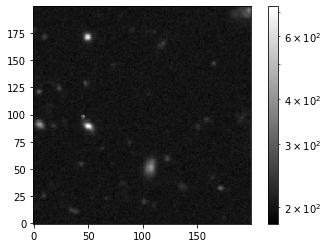

In [34]:
%%time
#D.stack(shifted=False, save_to_filename='mean_stack.fits')
D.stack(shifted=False)
print(D.stacked_data.data.min())
plt.imshow((D.stacked_data.data-D.stacked_data.data.min())[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

Combining images using median stacking.
CPU times: user 2.16 s, sys: 86.4 ms, total: 2.25 s
Wall time: 2.26 s


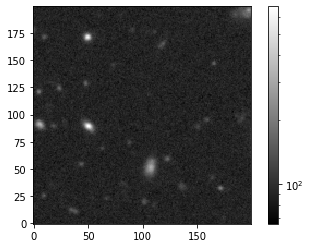

In [35]:
%%time
#D.stack(shifted=False, median_combine=True, save_to_filename='median_stack.fits')
D.stack(shifted=False, median_combine=True)
plt.imshow((D.stacked_data.data-D.stacked_data.data.min())[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

Now define some an array of shifts and shift the data. _.integer_shift_ can take a _padmean=True_ keyword to pad the shifted data with the mean value instead of NaN.

In [36]:
#Different shifts whether we're using 12 or 24 images:
if both_nights:
    shifts=np.array([620, 505]) - np.array([np.concatenate([np.linspace(253, 329, 12),
                                                            np.linspace(542, 620, 12)]),
                                            np.concatenate([np.linspace(288, 332, 12),
                                                            np.linspace(459, 505, 12)])]
                                           ).round(0).astype(int).T
else:
    shifts=np.array([620, 505]) - np.array([np.linspace(542, 620, 12),
                                            np.linspace(459, 505, 12)]
                                           ).round(0).astype(int).T
print(shifts)
D.integer_shift(shifts, padmean=True)
#D.integer_shift(shifts, padmean=False)

[[78 46]
 [71 42]
 [64 38]
 [57 33]
 [50 29]
 [43 25]
 [35 21]
 [28 17]
 [21 13]
 [14  8]
 [ 7  4]
 [ 0  0]]
Shifting image 0 by [78 46]
Shifting image 1 by [71 42]
Shifting image 2 by [64 38]
Shifting image 3 by [57 33]
Shifting image 4 by [50 29]
Shifting image 5 by [43 25]
Shifting image 6 by [35 21]
Shifting image 7 by [28 17]
Shifting image 8 by [21 13]
Shifting image 9 by [14  8]
Shifting image 10 by [7 4]
Shifting image 11 by [0 0]


_D.shifted_data_ now contains the shifted image array, which is slightly larger than the original so as to not cut out anything:

In [156]:
print(D.image_data.data.shape, D.image_data.WCS.shape, np.shape(D.image_data.header))
print(D.shifted_data.data.shape, D.shifted_data.WCS.shape, np.shape(D.shifted_data.header))

(12, 4176, 2048) (12,) (12, 645)
(12, 4254, 2094) (12,) (12, 641)


Now stack and save, both mean and median stacking. Again, mean is better for photometric properties, but median removes more of the star signal.

Combining images using mean stacking
272.72482
CPU times: user 122 ms, sys: 7.98 ms, total: 130 ms
Wall time: 129 ms


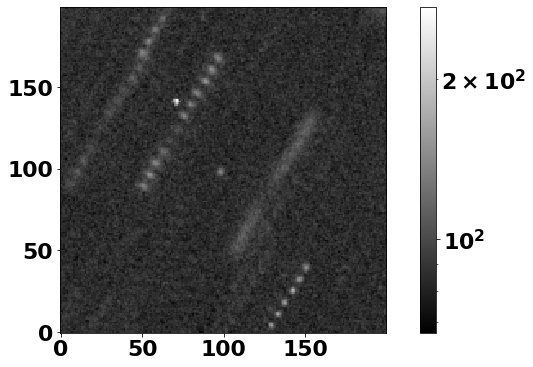

In [157]:
%%time
#D.stack(shifted=True, save_to_filename='shifted_mean_stack.fits')
D.stack(shifted=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
print(np.max((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605]))

Combining images using median stacking.
82.79175
CPU times: user 1.94 s, sys: 110 ms, total: 2.05 s
Wall time: 2.07 s


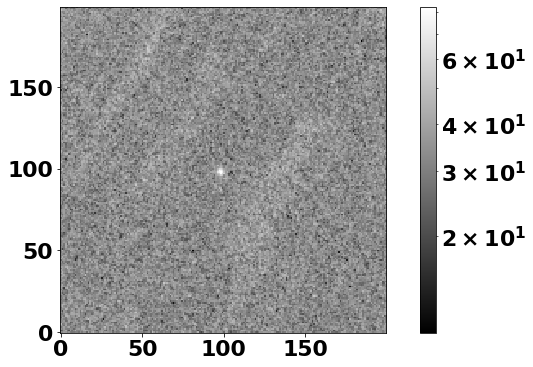

In [158]:
%%time
#D.stack(shifted=True, median_combine=True, save_to_filename='shifted_median_stack.fits')
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
print(np.max((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605]))



This is just an experiment. One can subtrack the mean non-shifted image from each image before shifting and median-combining for even better cleaning. 

Combining images using mean stacking
Shifting image 0 by [78 46]
Shifting image 1 by [71 42]
Shifting image 2 by [64 38]
Shifting image 3 by [57 33]
Shifting image 4 by [50 29]
Shifting image 5 by [43 25]
Shifting image 6 by [35 21]
Shifting image 7 by [28 17]
Shifting image 8 by [21 13]
Shifting image 9 by [14  8]
Shifting image 10 by [7 4]
Shifting image 11 by [0 0]
Combining images using median stacking.
Saving to file shifted_median_stack_clean.fits
Done!
112.24286
CPU times: user 3.88 s, sys: 311 ms, total: 4.19 s
Wall time: 4.21 s


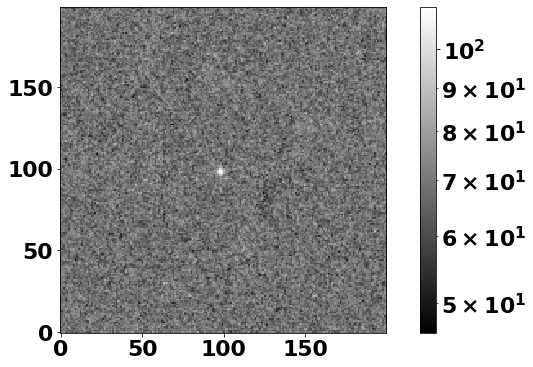

In [159]:
%%time
D=imagehandler.DataHandler(filenames)
D.stack(shifted=False, median_combine=False)
D.image_data.data=np.array([D.image_data.data[i]-D.stacked_data.data for i in np.arange(len(D.image_data.data))])
D.integer_shift(shifts, padmean=True)
D.stack(shifted=True, median_combine=True, save_to_filename='shifted_median_stack_clean.fits')
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
print(np.max((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605]))

#### Shift & Stacking a known object!
Here is a demonstration of the D._calculate_shifts_from_known method and the D.shift_stack_by_name method.

First, a demo of how D.calculate_shifts_from_known can be used to calculate the shifts for a known object (2015 RS281, a TNO), which can then be used to shift and stack the images:

[[  0.           0.        ]
 [ -4.37995215  -2.69892247]
 [-11.58666969  -7.11697158]
 [-18.61410525 -11.06377104]
 [-25.74755735 -15.21571409]
 [-33.16256842 -19.2984006 ]
 [-40.43085459 -23.17772984]
 [-48.11814599 -27.35217255]
 [-55.68660584 -31.92088157]
 [-63.19590173 -36.51840032]
 [-70.31711631 -40.91693826]
 [-77.87206501 -45.3925808 ]]
Shifting image 0 by [78 45]
Shifting image 1 by [74 42]
Shifting image 2 by [66 38]
Shifting image 3 by [59 34]
Shifting image 4 by [52 30]
Shifting image 5 by [45 26]
Shifting image 6 by [38 22]
Shifting image 7 by [30 18]
Shifting image 8 by [22 13]
Shifting image 9 by [15  8]
Shifting image 10 by [8 4]
Shifting image 11 by [0 0]
Combining images using median stacking.
CPU times: user 3.97 s, sys: 119 ms, total: 4.09 s
Wall time: 4.12 s


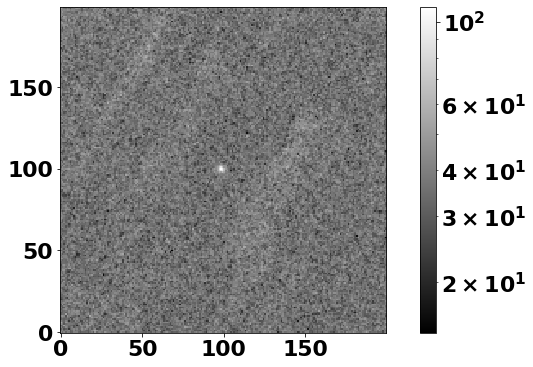

In [160]:
%%time
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
shifts = D._calculate_shifts_from_known(object_name='2015 RS281', obs_code='568')
print(shifts)
D.integer_shift(shifts, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

Or, even simpler, with the D.shift_stack_by_name method:

Combining images using mean stacking
Shifting image 0 by [78 45]
Shifting image 1 by [74 42]
Shifting image 2 by [66 38]
Shifting image 3 by [59 34]
Shifting image 4 by [52 30]
Shifting image 5 by [45 26]
Shifting image 6 by [38 22]
Shifting image 7 by [30 18]
Shifting image 8 by [22 13]
Shifting image 9 by [15  8]
Shifting image 10 by [8 4]
Shifting image 11 by [0 0]
[[  0.           0.        ]
 [ -4.37995215  -2.69892247]
 [-11.58666969  -7.11697158]
 [-18.61410525 -11.06377104]
 [-25.74755735 -15.21571409]
 [-33.16256842 -19.2984006 ]
 [-40.43085459 -23.17772984]
 [-48.11814599 -27.35217255]
 [-55.68660584 -31.92088157]
 [-63.19590173 -36.51840032]
 [-70.31711631 -40.91693826]
 [-77.87206501 -45.3925808 ]]
Combining images using median stacking.
Saving to file shift+stack_along_2015_RS281.fits
Done!
CPU times: user 4.27 s, sys: 174 ms, total: 4.44 s
Wall time: 4.45 s


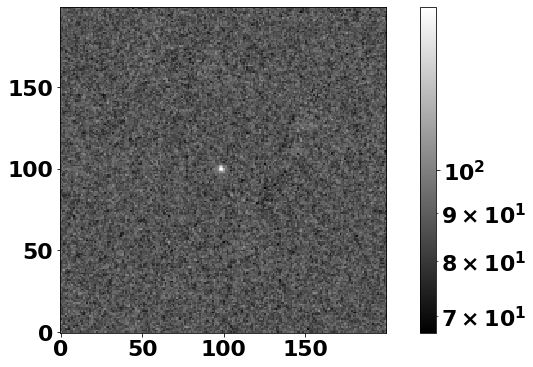

In [161]:
%%time
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.stack(shifted=False, median_combine=False)
D.image_data.data=np.array([D.image_data.data[i]-D.stacked_data.data for i in np.arange(len(D.image_data.data))])
D.shift_stack_by_name('2015 RS281', obs_code='568', padmean=True, median_combine=True)
D.save_stack('shift+stack_along_2015_RS281.fits')
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

Here's a different object (2008 SV52, an asteroid):

Combining images using mean stacking
Shifting image 0 by [460 366]
Shifting image 1 by [433 344]
Shifting image 2 by [392 310]
Shifting image 3 by [350 277]
Shifting image 4 by [308 244]
Shifting image 5 by [265 210]
Shifting image 6 by [222 176]
Shifting image 7 by [178 141]
Shifting image 8 by [132 105]
Shifting image 9 by [87 70]
Shifting image 10 by [44 36]
Shifting image 11 by [0 0]
[[   0.            0.        ]
 [ -26.70229963  -21.73463677]
 [ -68.38872714  -55.55490224]
 [-109.6475369   -88.55164923]
 [-151.71946476 -122.05782804]
 [-194.59970869 -155.9861608 ]
 [-237.6063582  -190.1779224 ]
 [-282.32924866 -225.29925118]
 [-327.72655725 -261.05443356]
 [-372.52773608 -296.12793755]
 [-415.84003565 -330.43369641]
 [-460.08837741 -365.89981842]]
Combining images using median stacking.
Saving to file shift+stack_along_2008_SV52.fits
Done!
CPU times: user 4.41 s, sys: 432 ms, total: 4.84 s
Wall time: 4.87 s


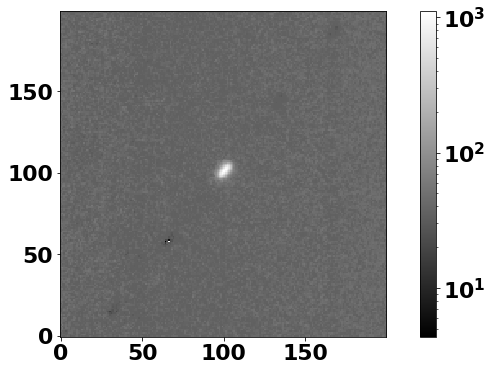

In [162]:
%%time
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.stack(shifted=False, median_combine=False)
D.image_data.data=np.array([D.image_data.data[i]-D.stacked_data.data for i in np.arange(len(D.image_data.data))])
D.shift_stack_by_name('2008 SV52', obs_code='568', padmean=True, median_combine=True)
D.save_stack('shift+stack_along_2008_SV52.fits')
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[3122:3322, 2088:2288], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

















# Junk & testing
These things are here mostly as a reminder to myself about some of the functionality of various packages/classes that might be helpful to take advantage of. 

In [196]:
import transformer
importlib.reload(transformer)

<module 'transformer' from '/home/mikea/GitHub/shifty/shifty/transformer.py'>

In [208]:
times = np.array([dh['SHIFTY_MJD_MID'] + 2400000.5 for dh in D.image_data.header])
abg=np.array([0., 0., -0.00001186, -0.01681588, 0.02403883, 0.00589040])
abg=np.array([0.00000992, 0.01426607, -0.00001172, -0.01711832, 0.02326049, 0.00000000])
abg=np.array([0.00000992, -0.00001172, 0.02326049, 0.01426607, -0.01711832, 0.00000000])
T=transformer.Transformer(times=times, time0=times[0]+9, radec0=np.array([10.26224583, 6.57555278]), verbose=True)
thetas=T(abg=abg, obs_code='568', method='JPL')

No verbosity implemented yet, sorry
No verbosity implemented yet, sorry
[[-0.13163891  0.00901034 -0.07805956]
 [-0.13141766  0.00899111 -0.07790261]
 [-0.1310729   0.00896107 -0.07765914]
 [-0.13073713  0.00893176 -0.07742332]
 [-0.13039734  0.00890211 -0.07718601]
 [-0.1300543   0.00887222 -0.07694775]
 [-0.12970933  0.00884227 -0.07670945]
 [-0.12935632  0.00881178 -0.07646688]
 [-0.12899775  0.00878102 -0.07622172]
 [-0.12864648  0.00875114 -0.07598263]
 [-0.1283039   0.00872229 -0.07575035]
 [-0.12795166  0.00869295 -0.0755123 ]]


In [254]:
np.degrees(thetas-np.min(thetas,0))*3600/0.17  # radians to pixels

array([[91.34337589,  5.85412057],
       [85.86818511,  5.50202824],
       [77.33394382,  4.95822732],
       [69.01968508,  4.43275781],
       [60.60373516,  3.90336191],
       [52.10542006,  3.36942792],
       [43.55782918,  2.83109536],
       [34.81006587,  2.27678638],
       [25.92376022,  1.7081715 ],
       [17.21817716,  1.14383722],
       [ 8.72837706,  0.58492151],
       [ 0.        ,  0.        ]])

In [255]:
np.degrees(thetas)*3600/0.17  # radians to pixels

array([[3294.7043408 ,  242.84636237],
       [3289.22915002,  242.49427004],
       [3280.69490873,  241.95046912],
       [3272.38064998,  241.42499961],
       [3263.96470006,  240.89560371],
       [3255.46638496,  240.36166972],
       [3246.91879408,  239.82333716],
       [3238.17103077,  239.26902818],
       [3229.28472512,  238.7004133 ],
       [3220.57914206,  238.13607901],
       [3212.08934197,  237.57716331],
       [3203.3609649 ,  236.9922418 ]])

In [256]:
shifts

array([[78, 46],
       [71, 42],
       [64, 38],
       [57, 33],
       [50, 29],
       [43, 25],
       [35, 21],
       [28, 17],
       [21, 13],
       [14,  8],
       [ 7,  4],
       [ 0,  0]])

In [62]:
np.degrees(thetas-np.min(thetas,0))*3600/0.17

array([[14.57438755,  0.        ],
       [13.69391593,  1.25864733],
       [12.32452834,  3.21620732],
       [10.99360827,  5.11877743],
       [ 9.649137  ,  7.04071919],
       [ 8.29378082,  8.97822108],
       [ 6.93231376, 10.92445857],
       [ 5.54016926, 12.91454991],
       [ 4.12657357, 14.93530605],
       [ 2.74166884, 16.91504803],
       [ 1.39044407, 18.84664403],
       [ 0.        , 20.83430458]])

In [173]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
matplotlib.rc('font', size=22, family='normal', weight='bold')

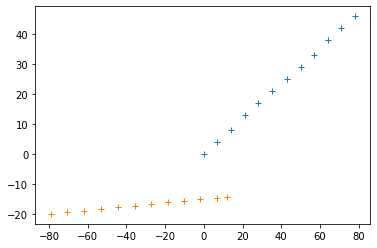

In [199]:
plt.plot(*shifts.T, '+')
plt.plot(*(np.degrees(thetas)*3600/0.17).T, '+')

In [178]:
def eq2ecl2(rad, decd, reverse=False):
    '''
    Function for quickly converting from equatorial (RA, Dec)
     to ecliptic latitude and longitude (l, b).
    '''
    epsilon = np.radians(-23.43928 if reverse else 23.43928)
    ra = np.radians((rad+180)%360-180)
    dec = np.radians(decd)
    sine = np.sin(epsilon)
    cose = np.cos(epsilon)
    sina = np.sin(ra)
    cosa = np.cos(ra)
    sind = np.sin(dec)
    cosd = np.cos(dec)
    sinb = cose * sind - sine * cosd * sina
    tanl = (cose * cosd * sina + sine * sind) / (cosd * cosa)
    l = np.arctan2((cose * cosd * sina + sine * sind), (cosd * cosa))
    latlon = np.degrees([l, np.arcsin(sinb)])
    return latlon

this doesn't look right


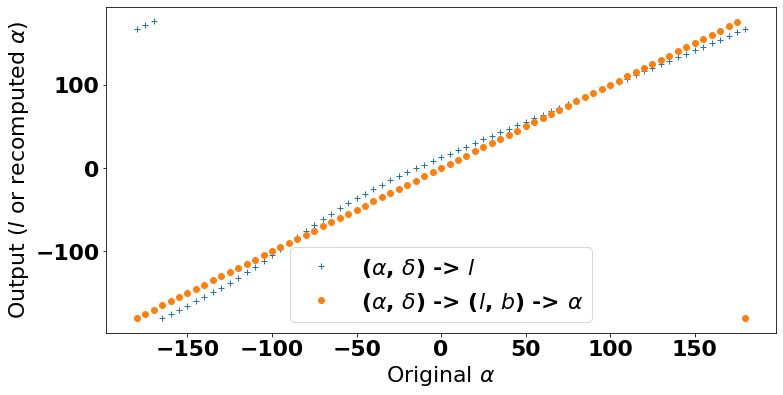

In [179]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
matplotlib.rc('font', size=22, family='normal', weight='bold')
input_radec = []
output_lonlat = []
output_radec = []
for rai in np.arange(-180, 181, 5):
    input_radec.append([rai, 30])
    output_lonlat.append(eq2ecl2(*input_radec[-1]))
    output_radec.append(eq2ecl2(*output_lonlat[-1], reverse=True))

input_radec = np.array(input_radec)
output_lonlat = np.array(output_lonlat)
output_radec = np.array(output_radec)

plt.plot(input_radec[:,0], output_lonlat[:, 0], '+', label=r'($\alpha$, $\delta$) -> $l$')
plt.plot(input_radec[:,0], output_radec[:, 0], 'o', label=r'($\alpha$, $\delta$) -> ($l$, $b$) -> $\alpha$')
plt.xlabel(r'Original $\alpha$')
plt.ylabel(r'Output ($l$ or recomputed $\alpha$)')
plt.legend()
print("this doesn't look right")

In [178]:
D.image_data.header

[SIMPLE  =                    T / Fits standard                                  
 BITPIX  =                  -32 / Bits per pixel                                 
 NAXIS   =                    2 / Number of axes                                 
 NAXIS1  =                 2048 / Axis length                                    
 NAXIS2  =                 4176 / Axis length                                    
 EXTEND  =                    F / File may contain extensions                    
 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
 DATE    = '2017-01-13T08:51:12' / Date FITS file was generated                  
 IRAF-TLM= '2017-01-13T08:51:12' / Time of last modification                     
 OBJECT  = 'LF09    '           / Name of the object observed                    
 BUNIT   = 'ADU     '           / Unit of original pixel value                   
 BLANK   =               -32768 / Value used for NULL pixels                     
 TIMESYS = 'UTC 

In [213]:
help(D.image_data.WCS)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

In [235]:
from astropy import wcs
D.image_data.header[0]['CRPIX1'], D.image_data.header[0]['CRPIX2']

(1018.49948929262, -4707.81052560967)

In [244]:
(D.image_data.WCS[0].all_pix2world([[1018,-4708]],0)-D.image_data.WCS[0].all_pix2world([[1019,-4708]],0))*3600

array([[-1.33984337e-04,  1.68781375e-01]])

In [245]:
(D.image_data.WCS[0].all_pix2world([[1018,-4708]],0)-D.image_data.WCS[0].all_pix2world([[1018,-4709]],0))*3600

array([[-1.69971038e-01, -5.59852740e-05]])

In [243]:
D.image_data.WCS[0].all_pix2world([[1018,-4708]],0)

array([[10.64343078,  6.6281254 ]])

In [247]:
np.mean([1.68781375e-1,1.69971038e-01])

0.16937620650000001